
# House Prices - Advanced Regression Techniques

In this notebook we will use a dataset provided by **Kaggle** for the competition [House Prices - Advanced Regression Techniques](https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques).  

First we will explore the data and do some basic EDA, and then we will implement both a Random Forest and a neural network model.

Before we start we need to import the resources (libraries, modules, etc.) that we will be using.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import root_mean_squared_error

import tensorflow as tf
import tensorflow_decision_forests as tfdf
from tensorflow.keras.layers import Input, Dense, Concatenate, Normalization, StringLookup, CategoryEncoding
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import RootMeanSquaredError

2025-05-16 13:52:23.974575: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-16 13:52:24.251307: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-16 13:52:24.485001: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747396344.741411  306980 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747396344.811161  306980 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747396345.316608  306980 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

As the data provided has many features, we will set up **Pandas** to display all columns and rows, making it easier to explore the data.

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

## 1. Initial exploration

The data provided by Kaggle has already been separated into train and test datasets, each in a different CSV file.  
Both datasets have the same format, the only difference is our target variable **SalePrice** is missing in the test set.
Along with the data, a file called data_description.txt is provided which contains a description of each column (and of their values in the categorical ones).

We will start by loading the training data and doing some basic exploration to understand what we are dealing with.

In [3]:
trainrawdata_path = '../data/raw/train.csv' # Path to the training dataset
traindf = pd.read_csv(trainrawdata_path)

In [4]:
traindf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

We can see that our training dataset has 1460 datapoints, with 79 features (81 columns but one is **Id** and another is the target variable **SalePrice**).  
There seems to be missing data in some features, which we will explore later.

In [5]:
traindf.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1379.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,567.240411,1057.429452,1162.626712,346.992466,5.844521,1515.463699,0.425342,0.057534,1.565068,0.382877,2.866438,1.046575,6.517808,0.613014,1978.506164,1.767123,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,441.866955,438.705324,386.587738,436.528436,48.623081,525.480383,0.518911,0.238753,0.550916,0.502885,0.815778,0.220338,1.625393,0.644666,24.689725,0.747315,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1900.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,223.000000,795.750000,882.000000,0.000000,0.000000,1129.500000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1961.000000,1.000000,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,477.500000,991.500000,1087.000000,0.000000,0.000000,1464.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1980.000000,2.000000,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,808.000000,1298.250000,1391.250000,728.000000,0.000000,1776.750000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2002.000000,2.000000,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,4692.000000,2065.000000,572.000000,5642.000000,3.000000,2.000000,3.000000,2.000000,8.000000,3.000000,14.000000,3.000000,2010.000000,4.000000,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [6]:
traindf.head(10)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,NaN,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,NaN,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
5,6,50,RL,85.0,14115,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1.5Fin,5,5,1993,1995,Gable,CompShg,VinylSd,VinylSd,NaN,0.0,TA,TA,Wood,Gd,TA,No,GLQ,732,Unf,0,64,796,GasA,Ex,Y,SBrkr,796,566,0,1362,1,0,1,1,1,1,TA,5,Typ,0,NaN,Attchd,1993.0,Unf,2,480,TA,TA,Y,40,30,0,320,0,0,NaN,MnPrv,Shed,700,10,2009,WD,Normal,143000
6,7,20,RL,75.0,10084,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,1Fam,1Story,8,5,2004,2005,Gable,CompShg,VinylSd,VinylSd,Stone,186.0,Gd,TA,PConc,Ex,TA,Av,GLQ,1369,Unf,0,317,1686,GasA,Ex,Y,SBrkr,1694,0,0,1694,1,0,2,0,3,1,Gd,7,Typ,1,Gd,Attchd,2004.0,RFn,2,636,TA,TA,Y,255,57,0,0,0,0,NaN,NaN,NaN,0,8,2007,WD,Normal,307000
7,8,60,RL,NaN,10382,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NWAmes,PosN,Norm,1Fam,2Story,7,6,1973,1973,Gable,CompShg,HdBoard,HdBoard,Stone,240.0,TA,TA,CBlock,Gd,TA,Mn,ALQ,859,BLQ,32,216,1107,GasA,Ex,Y,SBrkr,1107,983,0,2090,1,0,2,1,3,1,TA,7,Typ,2,TA,Attchd,1973.0,RFn,2,484,TA,TA,Y,235,204,228,0,0,0,NaN,NaN,Shed,350,11,2009,WD,Normal,200000
8,9,50,RM,51.0,6120,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Artery,Norm,1Fam,1.5Fin,7,5,1931,1950,Gable,CompShg,BrkFace,Wd Shng,NaN,0.0,TA,TA,BrkTil,TA,TA,No,Unf,0,Unf,0,952,952,GasA,Gd,Y,FuseF,1022,752,0,1774,0,0,2,0,2,2,TA,8,Min1,2,TA,Detchd,1931.0,Unf,2,468,Fa,TA,Y,90,0,205,0,0,0,NaN,NaN,NaN,0,4,2008,WD,Abnorml,129900
9,10,190,RL,50.0,7420,Pave,NaN,Reg,Lvl,AllPub,Corner,Gtl,BrkSide,Artery,Artery,2fmCon,1.5Unf,5,6,1939,1950,Gable,CompShg,MetalSd,MetalSd,NaN,0.0,TA,TA,BrkTil,TA,TA,No,GLQ,851,Unf,0,140,991,GasA,Ex,

After this first look we see that we have a mixed set of data, some columns are quantitative (numerical) like our target variable **SalePrice** or **LotArea** while many others are qualitative (categorical).  
Some of the categorical features are nominal but there are also ordinal variables like **OverallCond** which rates from 1 to 10 the overall condition of the house.

Lets have an initial look at our target variable **Saleprice**:

In [7]:
traindf['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

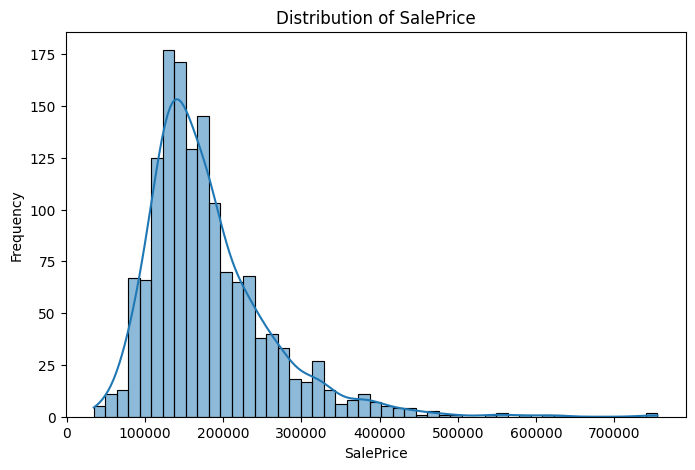

In [8]:
plt.figure(figsize=(8, 5))
sns.histplot(traindf['SalePrice'], kde=True)
plt.title('Distribution of SalePrice')
plt.xlabel('SalePrice')
plt.ylabel('Frequency')
plt.show()

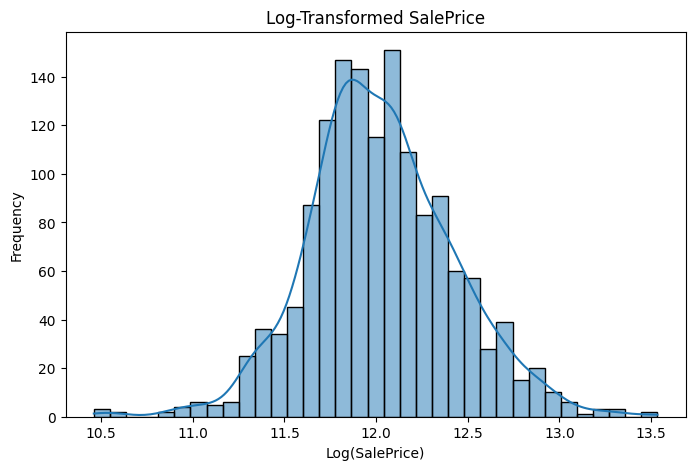

In [9]:
plt.figure(figsize=(8, 5))
sns.histplot(np.log1p(traindf['SalePrice']), kde=True)
plt.title('Log-Transformed SalePrice')
plt.xlabel('Log(SalePrice)')
plt.ylabel('Frequency')
plt.show()

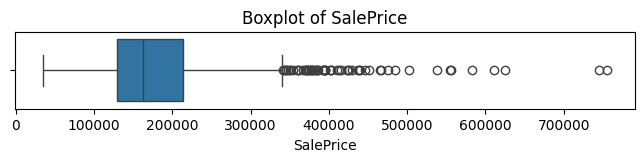

In [10]:
plt.figure(figsize=(8, 1))
sns.boxplot(x=traindf['SalePrice'])
plt.title('Boxplot of SalePrice')
plt.show()

After an initial look at our target variable **SalePrice** we can see a right-skewed distribution.  
This is to be expected as most houses will sell around the same price with the more expensive ones being fewer in number.

## 2. Missing Values Analysis & Handling

### 2.1 Missing values on training dataset

Now lets look at which features have missing values and how many each have.

In [11]:
traindf.isnull().sum().sort_values(ascending=False)[lambda x: x > 0]

PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
MasVnrType       872
FireplaceQu      690
LotFrontage      259
GarageQual        81
GarageFinish      81
GarageType        81
GarageYrBlt       81
GarageCond        81
BsmtFinType2      38
BsmtExposure      38
BsmtCond          37
BsmtQual          37
BsmtFinType1      37
MasVnrArea         8
Electrical         1
dtype: int64


As per the data_description.txt file, many of these features use NA as intented value, meaning "None".  
But there are other variables where that is not the case, like **GarageYrBlt** or **MasVnrArea**.  

As there are not that many features, lets explore them manually and deal with them accordingly.

**PoolQC** is a categorical variable which describes the quality of the pool, NA is not one of the categories but given that there is no category for "No pool", those 1453 missing values should mean that those 1453 houses have no pool.  

We can confirm this looking at how many houses have 0 pool area and checking if those entries are the same as the ones with **PoolQC** missing values.

In [12]:
(traindf['PoolArea'] == 0).sum()

np.int64(1453)

In [13]:
traindf[(traindf['PoolArea'] == 0) & (traindf['PoolQC'].isnull())].shape

(1453, 81)

Now lets transform empty values into a string "None" to avoid issues with missing values downstream.

In [14]:
traindf['PoolQC'] = traindf['PoolQC'].fillna('None')
traindf['PoolQC'].unique()

array(['None', 'Ex', 'Fa', 'Gd'], dtype=object)

**MiscFeature** is also a categorical variable with NA as intended value for None, lets compare it with **MiscVal** which represents the value of said feature.

In [15]:
(traindf['MiscVal'] == 0).sum()

np.int64(1408)

In [16]:
traindf[(traindf['MiscVal'] == 0) & (traindf['MiscFeature'].isnull())].shape

(1406, 81)

There seems to be 2 instances of **MiscVal** 0 more than the number of entries with **MiscFeature** as NA.  

In [17]:
traindf[(traindf['MiscVal'] == 0) & (traindf['MiscFeature'].notna())]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
873,874,40,RL,60.0,12144,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,5,7,1949,1950,Gable,CompShg,HdBoard,HdBoard,NaN,0.0,Gd,TA,CBlock,TA,TA,No,Rec,375,Unf,0,457,832,GasA,Gd,Y,SBrkr,1036,0,232,1268,0,0,1,0,3,1,TA,6,Typ,1,Gd,Attchd,1949.0,Unf,1,288,TA,TA,Y,0,28,0,0,0,0,None,NaN,Othr,0,9,2009,WD,Normal,133000
1200,1201,20,RL,71.0,9353,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,4,5,1970,1970,Gable,CompShg,MetalSd,MetalSd,NaN,0.0,TA,TA,CBlock,TA,TA,No,Unf,0,Unf,0,864,864,GasA,Gd,Y,SBrkr,864,0,0,864,0,0,1,0,3,1,TA,5,Typ,0,NaN,Attchd,1972.0,Unf,1,280,TA,TA,Y,0,0,0,0,0,0,None,NaN,Shed,0,7,2006,Oth,Abnorml,116050


As there are only 2 entries, we will drop them and replace the NA values of the rest of **MiscFeature** with "None".

In [18]:
traindf = traindf.drop(index=traindf[(traindf['MiscVal'] == 0) & (traindf['MiscFeature'].notna())].index)

In [19]:
traindf['MiscFeature'] = traindf['MiscFeature'].fillna('None')
traindf['MiscFeature'].unique()

array(['None', 'Shed', 'Gar2', 'Othr', 'TenC'], dtype=object)

Both **Alley** and **Fence** also use NA as None. This time there is no information to crosscheck, so we will assume all NA values are correct.

In [20]:
traindf['Alley'] = traindf['Alley'].fillna('None')
traindf['Alley'].unique()

array(['None', 'Grvl', 'Pave'], dtype=object)

In [21]:
traindf['Fence'] = traindf['Fence'].fillna('None')
traindf['Fence'].unique()

array(['None', 'MnPrv', 'GdWo', 'GdPrv', 'MnWw'], dtype=object)

**MasVnrType** is a categorical variable that describes the type of masonry veneer, and **MasVnrArea** is a numerical variable that measures its area in square feet.  
For the type there is a None category but with None instead of NA. Lets check its values:

In [22]:
(traindf['MasVnrArea'] == 0).sum()

np.int64(859)

In [23]:
traindf['MasVnrArea'].isnull().sum()

np.int64(8)

In [24]:
traindf['MasVnrType'].isnull().sum()

np.int64(870)

There seems to be some type of inconsistency here, as we have 870 missing values on **MasVnrType**, 8 missing values on **MasVnrArea**, and 859 values of 0 area.  
We should first check which rows have unexpected values.

In [25]:
traindf[(traindf['MasVnrArea'] > 0) & (traindf['MasVnrType'].isnull())]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
624,625,60,RL,80.0,10400,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,Norm,1Fam,2Story,6,5,1972,1972,Gable,CompShg,VinylSd,VinylSd,NaN,288.0,TA,TA,CBlock,TA,TA,No,Rec,247,Unf,0,485,732,GasA,Gd,Y,SBrkr,1012,778,0,1790,1,0,1,2,4,1,TA,8,Min2,1,TA,Attchd,1972.0,RFn,2,484,TA,TA,Y,148,0,0,0,147,0,None,None,None,0,11,2006,WD,Normal,165150
773,774,20,RL,70.0,10150,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,5,1958,1958,Gable,CompShg,Wd Sdng,Wd Sdng,NaN,1.0,TA,TA,CBlock,TA,TA,No,Rec,456,Unf,0,456,912,GasA,Ex,Y,FuseA,912,0,0,912,0,0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1958.0,RFn,1,275,TA,TA,Y,0,0,0,0,0,0,None,None,None,0,7,2007,COD,Normal,114500
1230,1231,90,RL,NaN,18890,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,Sawyer,Feedr,RRAe,Duplex,1.5Fin,5,5,1977,1977,Shed,CompShg,Plywood,Plywood,NaN,1.0,TA,TA,CBlock,Gd,TA,No,GLQ,498,Rec,211,652,1361,GasA,Ex,Y,SBrkr,1361,1259,0,2620,0,0,2,2,4,2,TA,12,Typ,1,TA,BuiltIn,1977.0,RFn,2,600,TA,TA,N,155,24,145,0,0,0,None,None,Gar2,8300,8,2007,WD,Normal,190000
1300,1301,60,RL,NaN,10762,Pave,None,IR1,Lvl,AllPub,CulDSac,Gtl,Gilbert,Norm,Norm,1Fam,2Story,7,5,1999,1999,Gable,CompShg,VinylSd,VinylSd,NaN,344.0,Gd,TA,PConc,Gd,TA,No,GLQ,694,Unf,0,284,978,GasA,Ex,Y,SBrkr,1005,978,0,1983,0,0,2,1,3,1,Gd,9,Typ,1,TA,Attchd,1999.0,Fin,2,490,TA,TA,Y,0,0,0,0,0,0,None,None,None,0,5,2009,WD,Normal,225000
1334,1335,160,RM,24.0,2368,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,BrDale,Norm,Norm,TwnhsE,2Story,5,6,1970,1970,Gable,CompShg,HdBoard,HdBoard,NaN,312.0,TA,TA,CBlock,TA,TA,No,LwQ,765,Unf,0,0,765,GasA,TA,Y,SBrkr,765,600,0,1365,0,0,1,1,3,1,TA,7,Min1,0,NaN,Attchd,1970.0,Unf,2,440,TA,TA,Y,0,36,0,0,0,0,None,None,None,0,5,2009,WD,Normal,125000


In [26]:
traindf[(traindf['MasVnrArea'].isnull())]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
234,235,60,RL,NaN,7851,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,5,2002,2002,Gable,CompShg,VinylSd,VinylSd,NaN,NaN,Gd,TA,PConc,Gd,TA,No,GLQ,625,Unf,0,235,860,GasA,Ex,Y,SBrkr,860,1100,0,1960,1,0,2,1,4,1,Gd,8,Typ,2,TA,BuiltIn,2002.0,Fin,2,440,TA,TA,Y,288,48,0,0,0,0,None,None,None,0,5,2010,WD,Normal,216500
529,530,20,RL,NaN,32668,Pave,None,IR1,Lvl,AllPub,CulDSac,Gtl,Crawfor,Norm,Norm,1Fam,1Story,6,3,1957,1975,Hip,CompShg,Wd Sdng,Stone,NaN,NaN,Gd,TA,PConc,TA,TA,No,Rec,1219,Unf,0,816,2035,GasA,TA,Y,SBrkr,2515,0,0,2515,1,0,3,0,4,2,TA,9,Maj1,2,TA,Attchd,1975.0,RFn,2,484,TA,TA,Y,0,0,200,0,0,0,None,None,None,0,3,2007,WD,Alloca,200624
650,651,60,FV,65.0,8125,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,1Fam,2Story,7,6,2007,2007,Gable,CompShg,CemntBd,CmentBd,NaN,NaN,Gd,TA,PConc,Gd,TA,No,Unf,0,Unf,0,813,813,GasA,Ex,Y,SBrkr,822,843,0,1665,0,0,2,1,3,1,Gd,7,Typ,0,NaN,Attchd,2007.0,RFn,2,562,TA,TA,Y,0,0,0,0,0,0,None,None,None,0,5,2008,WD,Normal,205950
936,937,20,RL,67.0,10083,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,SawyerW,Norm,Norm,1Fam,1Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,NaN,NaN,Gd,TA,PConc,Gd,TA,No,GLQ,833,Unf,0,343,1176,GasA,Ex,Y,SBrkr,1200,0,0,1200,1,0,2,0,2,1,Gd,5,Typ,0,NaN,Attchd,2003.0,RFn,2,555,TA,TA,Y,0,41,0,0,0,0,None,None,None,0,8,2009,WD,Normal,184900
973,974,20,FV,95.0,11639,Pave,None,Reg,Lvl,AllPub,Corner,Gtl,Somerst,Norm,Norm,1Fam,1Story,7,5,2007,2008,Gable,CompShg,CemntBd,CmentBd,NaN,NaN,Gd,TA,PConc,Gd,TA,No,Unf,0,Unf,0,1428,1428,GasA,Ex,Y,SBrkr,1428,0,0,1428,0,0,2,0,3,1,Gd,6,Typ,0,NaN,Attchd,2007.0,Fin,2,480,TA,TA,Y,0,120,0,0,0,0,None,None,None,0,12,2008,New,Partial,182000
977,978,120,FV,35.0,4274,Pave,Pave,IR1,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,TwnhsE,1Story,7,5,2006,2007,Gable,CompShg,VinylSd,VinylSd,NaN,NaN,Gd,TA,PConc,Gd,TA,No,GLQ,1106,Unf,0,135,1241,GasA,Ex,Y,SBrkr,1241,0,0,1241,1,0,1,1,1,1,Gd,4,Typ,0,NaN,Attchd,2007.0,Fin,2,569,TA,TA,Y,0,116,0,0,0,0,None,None,None,0,11,2007,New,Partial,199900
1243,1244,20,RL,107.0,13891,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,NridgHt,Norm,Norm,1Fam,1Story,10,5,2006,2006,Gable,CompShg,VinylSd,VinylSd,NaN,NaN,Ex,TA,PConc,Ex,Gd,Gd,GLQ,1386,Unf,0,690,2076,GasA,Ex,Y,SBrkr,2076,0,0,2076,1,0,2,1,2,1,Ex,7,Typ,1,Gd,Attchd,2006.0,Fin,3,850,TA,TA,Y,216,229,0,0,0,0,None,None,None,0,9,2006,New,Partial,465000
1278,1279,60,RL,75.0,9473,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,8,5,2002,2002,Gable,CompShg,VinylSd,VinylSd,NaN,NaN,Gd,TA,PConc,Gd,TA,No,GLQ,804,Unf,0,324,1128,GasA,Ex,Y,SBrkr,1128,903,0,2031,1,0,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,2002.0,RFn,2,577,TA,TA,Y,0,211,0,0,0,0,None,None,None,0,3,2008,WD,Normal,237000


In [27]:
traindf[(traindf['MasVnrArea'] == 0) & ~(traindf['MasVnrType'].isnull())]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
688,689,20,RL,60.0,8089,Pave,None,Reg,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,1Fam,1Story,8,6,2007,2007,Gable,CompShg,MetalSd,MetalSd,BrkFace,0.0,Gd,TA,PConc,Gd,TA,Av,GLQ,945,Unf,0,474,1419,GasA,Ex,Y,SBrkr,1419,0,0,1419,1,0,2,0,2,1,Gd,7,Typ,1,Gd,Attchd,2007.0,RFn,2,567,TA,TA,Y,140,0,0,0,0,0,None,None,None,0,10,2007,New,Partial,392000
1241,1242,20,RL,83.0,9849,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,1Fam,1Story,7,6,2007,2007,Hip,CompShg,VinylSd,VinylSd,Stone,0.0,Gd,TA,PConc,Gd,TA,Av,Unf,0,Unf,0,1689,1689,GasA,Ex,Y,SBrkr,1689,0,0,1689,0,0,2,0,3,1,Gd,7,Typ,0,NaN,Attchd,2007.0,RFn,3,954,TA,TA,Y,0,56,0,0,0,0,None,None,None,0,6,2007,New,Partial,248328


We can see 4 different cases here:  
> 8 entries where both type and area are NA  
> 2 entries where type is NA but where the area is 1.0, which would not make sense as that area value is too small  
> 3 entries where type is NA but where the area has a reasonable value  
> 2 entries where there is a valid type but the area is 0  

We are going to drop the entries with both values missing, and the two with 1.0 as area, because they are only 10 entries (<1% of the total).  

As for the other two cases, we are going to replace the missing values with the mode of the type from its neighborhood, and with the median of the neighborhood of the area.

In [28]:
traindf = traindf.drop(index=traindf[(traindf['MasVnrType'].isnull()) & (traindf['MasVnrArea'].isnull())].index)
traindf = traindf.drop(index=traindf[(traindf['MasVnrArea'] == 1.0)].index)

In [29]:
# Create boolean mask for those rows where MasVnrType is NaN and MasVnrArea is not 0
mask1 = traindf['MasVnrType'].isna() & (traindf['MasVnrArea'] != 0)

# Create boolean mask for those rows where MasVnrType has a valid value and MasVnrArea is 0
mask2 = ~traindf['MasVnrType'].isna() & (traindf['MasVnrArea'] == 0)

# Group by Neighborhood and get the mode of MasVnrType by Neighborhood and the median of MasVnrArea.
MasVnrType_mode_Neighborhood = (traindf.groupby('Neighborhood')['MasVnrType'].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else 'None'))
MasVnrArea_median_Neighborhood = traindf.groupby('Neighborhood')['MasVnrArea'].median()

# Map the mode values to the original DataFrame
traindf.loc[mask1, 'MasVnrType'] = traindf.loc[mask1, 'Neighborhood'].map(MasVnrType_mode_Neighborhood)
traindf.loc[mask2, 'MasVnrArea'] = traindf.loc[mask2, 'Neighborhood'].map(MasVnrArea_median_Neighborhood)

Lets check whether all the missing values remaining matches the number of properties without masonry veneer.

In [30]:
print(traindf['MasVnrType'].isnull().sum())
print((traindf['MasVnrArea'] == 0).sum())
traindf[(traindf['MasVnrArea'] == 0) & ~(traindf['MasVnrType'].isnull())]

857
858


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
688,689,20,RL,60.0,8089,Pave,None,Reg,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,1Fam,1Story,8,6,2007,2007,Gable,CompShg,MetalSd,MetalSd,BrkFace,0.0,Gd,TA,PConc,Gd,TA,Av,GLQ,945,Unf,0,474,1419,GasA,Ex,Y,SBrkr,1419,0,0,1419,1,0,2,0,2,1,Gd,7,Typ,1,Gd,Attchd,2007.0,RFn,2,567,TA,TA,Y,140,0,0,0,0,0,None,None,None,0,10,2007,New,Partial,392000


We can see there is still an entry with valid veneer type but area 0, this means that the median of that neighborhood is 0.  
As it is only one entry, our safest approach is to just drop this one entry.

In [31]:
traindf = traindf.drop(index=traindf[(traindf['MasVnrArea'] == 0) & ~(traindf['MasVnrType'].isnull())].index)

Now we will replace the NA values in type by 'None'.

In [32]:
traindf['MasVnrType'] = traindf['MasVnrType'].fillna('None')
traindf['MasVnrType'].unique()

array(['BrkFace', 'None', 'Stone', 'BrkCmn'], dtype=object)

**FireplaceQu** has NA as None, and the amount should match the amount of 0 **Fireplaces**.  
If so, we will just replace those NA with "None".

In [33]:
(traindf['FireplaceQu'].isnull()).sum()

np.int64(684)

In [34]:
(traindf['Fireplaces'] == 0).sum()

np.int64(684)

In [35]:
traindf[(traindf['Fireplaces'] == 0) & (traindf['FireplaceQu'].isnull())].shape

(684, 81)

In [36]:
traindf['FireplaceQu'] = traindf['FireplaceQu'].fillna('None')
traindf['FireplaceQu'].unique()

array(['None', 'TA', 'Gd', 'Fa', 'Ex', 'Po'], dtype=object)

**LotFrontage** shows the linear feet of street connected to the house.  
As there is a big number of missing values (~17%), dropping them would not be reasonable.  
Instead, we will replace those values by the median of the neighborhood.

In [37]:
# Create boolean mask for those rows where LotFrontage is NA.
mask = traindf['LotFrontage'].isna()

# Group by Neighborhood and get the mode of LotFrontage by Neighborhood
LotFrontage_median_Neighborhood = traindf.groupby('Neighborhood')['LotFrontage'].median()

# Map the mode values to the original DataFrame
traindf.loc[mask, 'LotFrontage'] = traindf.loc[mask, 'Neighborhood'].map(LotFrontage_median_Neighborhood)

In [38]:
(traindf['LotFrontage'].isnull()).sum()

np.int64(0)

Now we will check the garage related variables.
We have 81 missing values on **GarageQual, GarageType, GarageFinish, GarageYrBlt, GarageExposure**.  
All those are categorical and have NA as legitimate value for "no garage", except **GarageYrBlt** which is numerical (year the garage was built).  

Besides those, we can see two more variables related to the garage, **GarageArea** and **GarageCars** which are numerical variables.

Now we should check that those 81 missing values on each feature, they all match 81 unique entries, that at the same time should have all of them 0 in both Area and Cars.

In [39]:
(traindf['GarageCars'] == 0).sum()

np.int64(81)

In [40]:
(traindf['GarageArea'] == 0).sum()

np.int64(81)

In [41]:
traindf[(traindf['GarageArea'] == 0) & (traindf['GarageCars'] == 0) & (traindf['GarageQual'].isnull()) 
        & (traindf['GarageType'].isnull()) & (traindf['GarageFinish'].isnull()) 
        & (traindf['GarageCond'].isnull()) & (traindf['GarageYrBlt'].isnull())].shape

(81, 81)

After checking this we can safely replace NA values on the categorical variables with "None", and for **GarageYrBlt** we will replace with -1 as a placeholder to indicate there is no garage.

In [42]:
for var in ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']:
    traindf[var] = traindf[var].fillna('None')
    print(f"Unique values in {var}: {traindf[var].unique()}")
traindf['GarageYrBlt'] = traindf['GarageYrBlt'].fillna(-1)
(traindf['GarageYrBlt'] == -1).sum()

Unique values in GarageType: ['Attchd' 'Detchd' 'BuiltIn' 'CarPort' 'None' 'Basment' '2Types']
Unique values in GarageFinish: ['RFn' 'Unf' 'Fin' 'None']
Unique values in GarageQual: ['TA' 'Fa' 'Gd' 'None' 'Ex' 'Po']
Unique values in GarageCond: ['TA' 'Fa' 'None' 'Gd' 'Po' 'Ex']


np.int64(81)

As far as basement related variables, we have 11 in total:
> **BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1, BsmtFinType2**, these 5 categorical features use NA as value for "no basement", and those are the ones that show missing values.  
> **BsmtFinSF1, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF**, these 4 numerical features describe the area in square feet of the different sections of the basement, they have no missing values.  
> **BsmtFullBath, BsmtHalfBath**, these 2 numerical features describe the amount of full and half bathrooms that there are in the basement, they have no missing values.  

We expect to see that those entries with missing values in all 5 categorical features, should have 0 as value in all the numerical variables.  
First we will check that and replace the missing values with "None" and then we can focus in the rest of the missing values.

In [43]:
BsmtCatCols = ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']
mask = traindf[BsmtCatCols].isnull().all(axis=1)

print("Basement 1 area: ", 
      traindf[mask]["BsmtFinSF1"].value_counts())

print("Basement 2 area: ", 
      traindf[mask]["BsmtFinSF2"].value_counts())

print("Unfinished basement area: ", 
      traindf[mask]["BsmtUnfSF"].value_counts())

print("Basement total area: ", 
      traindf[mask]["TotalBsmtSF"].value_counts())

print("Basement full bathrooms: ", 
      traindf[mask]["BsmtFullBath"].value_counts())

print("Basement half bathrooms: ", 
      traindf[mask]["BsmtHalfBath"].value_counts())

Basement 1 area:  BsmtFinSF1
0    37
Name: count, dtype: int64
Basement 2 area:  BsmtFinSF2
0    37
Name: count, dtype: int64
Unfinished basement area:  BsmtUnfSF
0    37
Name: count, dtype: int64
Basement total area:  TotalBsmtSF
0    37
Name: count, dtype: int64
Basement full bathrooms:  BsmtFullBath
0    37
Name: count, dtype: int64
Basement half bathrooms:  BsmtHalfBath
0    37
Name: count, dtype: int64


With that we can safely replace in those 37 entries the missing value with "None".

In [44]:
traindf.loc[mask, BsmtCatCols] = traindf.loc[mask, BsmtCatCols].fillna('None')

Lets check what missing values remain.

In [45]:
traindf.isnull().sum().sort_values(ascending=False)[lambda x: x > 0]

BsmtExposure    1
BsmtFinType2    1
Electrical      1
dtype: int64

In [46]:
traindf[traindf["BsmtExposure"].isnull() | traindf["BsmtFinType2"].isnull()]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
332,333,20,RL,85.0,10655,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,NridgHt,Norm,Norm,1Fam,1Story,8,5,2003,2004,Gable,CompShg,VinylSd,VinylSd,BrkFace,296.0,Gd,TA,PConc,Gd,TA,No,GLQ,1124,NaN,479,1603,3206,GasA,Ex,Y,SBrkr,1629,0,0,1629,1,0,2,0,3,1,Gd,7,Typ,1,Gd,Attchd,2003.0,RFn,3,880,TA,TA,Y,0,0,0,0,0,0,None,None,None,0,10,2009,WD,Normal,284000
948,949,60,RL,65.0,14006,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2002,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,144.0,Gd,TA,PConc,Gd,TA,NaN,Unf,0,Unf,0,936,936,GasA,Ex,Y,SBrkr,936,840,0,1776,0,0,2,1,3,1,Gd,7,Typ,1,TA,Attchd,2002.0,RFn,2,474,TA,TA,Y,144,96,0,0,0,0,None,None,None,0,2,2006,WD,Normal,192500


We can see that there is one entry with **BsmtFinType2** empty even though there is surface area and the other values make sense, and another entry where **BsmtExposure**'s value is missing even though the rest of the values indicate that there is an unfinished basement. Both cases seem to be missing information, not empty on purpose.  

Given that it is only 2 entries, we will drop them.

In [47]:
traindf = traindf.drop(index=traindf[traindf["BsmtExposure"].isnull() | traindf["BsmtFinType2"].isnull()].index)

As for the entry with the **Electrical** feature missing, we will drop it too.

In [48]:
traindf = traindf.drop(index=traindf[traindf["Electrical"].isnull()].index)

Before we proceed lets check all missing values have been dealt with:

In [49]:
traindf.isnull().sum().sort_values(ascending=False)[lambda x: x > 0]

Series([], dtype: int64)

An empty list means there are no more missing values in our data.

In [50]:
traindf.shape

(1444, 81)

We have lost in total 16 rows (~1%), but now we have a clean dataset that will not give us problems when we implement any models that cannot deal with missing values natively.

Lets save the cleaned dataset into a CSV file before proceeding with the next steps.

In [51]:
train_clean_output_path = '../data/processed/train_clean.csv'  # Output file path
traindf.to_csv(train_clean_output_path, index=False)

### 2.2 Missing values on test dataset

Now we will repeat the same operations with the test dataset provided, but without dropping any rows as we will need to make a prediction from all of them.  

We will start by loading the test set.

In [52]:
rawtestdata_path = '../data/raw/test.csv' # Path to the test dataset
testdf = pd.read_csv(rawtestdata_path)

In [53]:
testdf.isnull().sum().sort_values(ascending=False)[lambda x: x > 0]

PoolQC          1456
MiscFeature     1408
Alley           1352
Fence           1169
MasVnrType       894
FireplaceQu      730
LotFrontage      227
GarageYrBlt       78
GarageCond        78
GarageFinish      78
GarageQual        78
GarageType        76
BsmtCond          45
BsmtQual          44
BsmtExposure      44
BsmtFinType1      42
BsmtFinType2      42
MasVnrArea        15
MSZoning           4
BsmtHalfBath       2
Utilities          2
Functional         2
BsmtFullBath       2
BsmtFinSF1         1
Exterior1st        1
TotalBsmtSF        1
BsmtUnfSF          1
BsmtFinSF2         1
SaleType           1
KitchenQual        1
GarageCars         1
GarageArea         1
Exterior2nd        1
dtype: int64

We have more features with missing values in the test dataset than in the train set, but most seem to be one or two entries.  

As we cannot drop rows on the test set given that we need to make a prediction for all of them, lets first apply carefully the same transformations as with the training set and see what remains.

In [54]:
# Replace NA with 'None' in every missing PoolQC that has PoolArea = 0
mask = (testdf["PoolArea"] == 0) & (testdf["PoolQC"].isnull())
testdf.loc[mask, "PoolQC"] = 'None'

# Replace NA with 'None' in every missing MiscFeature that has MiscVal = 0
mask = (testdf["MiscVal"] == 0) & (testdf["MiscFeature"].isnull())
testdf.loc[mask, "MiscFeature"] = 'None'

# Replace NA with 'None' in every missing Alley and Fence
testdf['Alley'] = testdf['Alley'].fillna('None')
testdf['Fence'] = testdf['Fence'].fillna('None')

# For those with both MasVnrtype and MasVnrArea missing, we will first replace the area with the median of the neighborhood from the training set
mask = testdf['MasVnrType'].isna() & (testdf['MasVnrArea'].isna())
testdf.loc[mask, 'MasVnrArea'] = testdf.loc[mask, 'Neighborhood'].map(MasVnrArea_median_Neighborhood)
# Then replace the MasVnrType with the mode of the neighborhood from the training set on those rows with a valid MasVnrArea (>0)
mask = testdf['MasVnrType'].isna() & (testdf['MasVnrArea'] > 0)
testdf.loc[mask, 'MasVnrType'] = testdf.loc[mask, 'Neighborhood'].map(MasVnrType_mode_Neighborhood)
# And for those with MasVnrArea = 0 and MasVnrType missing, we will replace the type with 'None'
mask = testdf['MasVnrType'].isna() & (testdf['MasVnrArea'] == 0)
testdf.loc[mask, "MasVnrType"] = 'None'

# Replace NA with 'None' in every missing FireplaceQu that has Fireplaces = 0
mask = (testdf["Fireplaces"] == 0) & (testdf["FireplaceQu"].isnull())
testdf.loc[mask, "FireplaceQu"] = 'None'

# Replace NA with the median LotFrontage of the neighborhood from the training set
mask = testdf['LotFrontage'].isna()
testdf.loc[mask, 'LotFrontage'] = testdf.loc[mask, 'Neighborhood'].map(LotFrontage_median_Neighborhood)

# Replace NA with 'None' in every missing categorical Garage variables, with -1 in GarageYrBlt and with 0 in GarageArea and GarageCars
# But only for those entries where all Garage variables mean there is no garage
mask = (
    ((testdf['GarageArea'].isnull()) | (testdf['GarageArea'] == 0)) &
    ((testdf['GarageCars'].isnull()) | (testdf['GarageCars'] == 0)) &
    (testdf['GarageQual'].isnull()) &
    (testdf['GarageType'].isnull()) &
    (testdf['GarageFinish'].isnull()) &
    (testdf['GarageCond'].isnull()) &
    ((testdf['GarageYrBlt'].isnull()) | (testdf['GarageYrBlt'] == 0))
)

for var in ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']:
    testdf.loc[mask, var] = 'None'
testdf.loc[mask, 'GarageYrBlt'] = -1
testdf.loc[mask, 'GarageArea'] = 0
testdf.loc[mask, 'GarageCars'] = 0



# Replace NA with 'None' in every missing categorical Basement variables, and with 0 in the numerical ones
# But only for those entries where all Basement variables mean there is no basement
mask = (
    ((testdf['BsmtFinSF1'].isnull()) | (testdf['BsmtFinSF1'] == 0)) &
    ((testdf['BsmtFinSF2'].isnull()) | (testdf['BsmtFinSF2'] == 0)) &
    ((testdf['BsmtUnfSF'].isnull()) | (testdf['BsmtUnfSF'] == 0)) &
    ((testdf['TotalBsmtSF'].isnull()) | (testdf['TotalBsmtSF'] == 0)) &
    ((testdf['BsmtFullBath'].isnull()) | (testdf['BsmtFullBath'] == 0)) &
    ((testdf['BsmtHalfBath'].isnull()) | (testdf['BsmtHalfBath'] == 0)) &
    (testdf['BsmtQual'].isnull()) &
    (testdf['BsmtCond'].isnull()) &
    (testdf['BsmtExposure'].isnull()) &
    (testdf['BsmtFinType1'].isnull()) &
    (testdf['BsmtFinType2'].isnull())
)
for var in ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']:
    testdf.loc[mask, var] = 'None'
for var in ['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath']:
    testdf.loc[mask, var] = 0

Afther that transformation the missing values remaining are the following.

In [55]:
testdf.isnull().sum().sort_values(ascending=False)[lambda x: x > 0]

MSZoning        4
BsmtCond        3
PoolQC          3
Utilities       2
BsmtQual        2
BsmtExposure    2
GarageFinish    2
GarageQual      2
GarageCond      2
Functional      2
GarageYrBlt     2
GarageArea      1
Exterior1st     1
KitchenQual     1
GarageCars      1
Exterior2nd     1
MiscFeature     1
SaleType        1
dtype: int64

In [56]:
testdf.isnull().any(axis=1).sum()

np.int64(22)

Most missing values have been cleaned, but there are a few remnants over 22 entries that we will deal with manually.  

Using the information provided in data_description.txt we will proceed with the following:

- **MSZoning** we will replace missing values with the mode by neighborhood from the training set
- **PoolQC** we will replace missing values with the mode by neighborhood from the training set (we previously already replaced those with 0 **PoolArea** by "None")
- **Utilities** we will replace missing values with the mode by neighborhood from the training set
- **Functional** we will replace missing values with "Typ" (From documentation: Assume typical unless deductions are warranted)
- **Exterior1st** we will replace missing values with the mode by neighborhood from the training set
- **Exterior2nd** we will replace missing values with the mode by neighborhood from the training set
- **KitchenQual** we will replace missing values with the mode by neighborhood from the training set
- **MiscFeature** we will replace missing values with "Other" category (we previously already replaced those with 0 **MiscVal** by "None)
- **SaleType** we will replace missing values with the mode by neighborhood from the training set

In [57]:
mask = testdf['MSZoning'].isna()
MSZoning_mode_Neighborhood = (traindf.groupby('Neighborhood')['MSZoning'].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else 'None'))
testdf.loc[mask, 'MSZoning'] = testdf.loc[mask, 'Neighborhood'].map(MSZoning_mode_Neighborhood)

mask = testdf['PoolQC'].isna()
PoolQC_mode_Neighborhood = (traindf.groupby('Neighborhood')['PoolQC'].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else 'None'))
testdf.loc[mask, 'PoolQC'] = testdf.loc[mask, 'Neighborhood'].map(PoolQC_mode_Neighborhood)

mask = testdf['Utilities'].isna()
Utilities_mode_Neighborhood = (traindf.groupby('Neighborhood')['Utilities'].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else 'None'))
testdf.loc[mask, 'Utilities'] = testdf.loc[mask, 'Neighborhood'].map(Utilities_mode_Neighborhood)

mask = testdf['Functional'].isna()
testdf.loc[mask, 'Functional'] = "Typ"

mask = testdf['Exterior1st'].isna()
Exterior1st_mode_Neighborhood = (traindf.groupby('Neighborhood')['Exterior1st'].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else 'None'))
testdf.loc[mask, 'Exterior1st'] = testdf.loc[mask, 'Neighborhood'].map(Exterior1st_mode_Neighborhood)

mask = testdf['Exterior2nd'].isna()
Exterior2nd_mode_Neighborhood = (traindf.groupby('Neighborhood')['Exterior2nd'].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else 'None'))
testdf.loc[mask, 'Exterior2nd'] = testdf.loc[mask, 'Neighborhood'].map(Exterior2nd_mode_Neighborhood)

mask = testdf['KitchenQual'].isna()
KitchenQual_mode_Neighborhood = (traindf.groupby('Neighborhood')['KitchenQual'].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else 'None'))
testdf.loc[mask, 'KitchenQual'] = testdf.loc[mask, 'Neighborhood'].map(KitchenQual_mode_Neighborhood)

mask = testdf['MiscFeature'].isna()
testdf.loc[mask, 'MiscFeature'] = "Other"

mask = testdf['SaleType'].isna()
SaleType_mode_Neighborhood = (traindf.groupby('Neighborhood')['SaleType'].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else 'None'))
testdf.loc[mask, 'SaleType'] = testdf.loc[mask, 'Neighborhood'].map(SaleType_mode_Neighborhood)

We should have left the Basement and Garage related variables.

In [58]:
testdf.isnull().sum().sort_values(ascending=False)[lambda x: x > 0]

BsmtCond        3
GarageFinish    2
GarageYrBlt     2
GarageQual      2
BsmtQual        2
BsmtExposure    2
GarageCond      2
GarageArea      1
GarageCars      1
dtype: int64

In [59]:
testdf.isnull().any(axis=1).sum()

np.int64(9)

They are only 9 entries, lets explore them:

In [60]:
testdf[testdf.isnull().any(axis=1)]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
27,1488,20,RL,73.0,8987,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,1Fam,1Story,8,5,2005,2006,Gable,CompShg,VinylSd,VinylSd,BrkFace,226.0,Gd,TA,PConc,Gd,TA,NaN,Unf,0.0,Unf,0.0,1595.0,1595.0,GasA,Ex,Y,SBrkr,1595,0,0,1595,0.0,0.0,2,0,2,1,Gd,6,Typ,1,Gd,Attchd,2005.0,RFn,3.0,880.0,TA,TA,Y,144,0,0,0,0,0,None,None,None,0,5,2010,WD,Normal
580,2041,20,RL,103.0,16280,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,Veenker,Norm,Norm,1Fam,1Story,8,9,1976,2007,Gable,CompShg,VinylSd,VinylSd,None,0.0,Ex,Ex,CBlock,Gd,NaN,Mn,GLQ,1044.0,Rec,382.0,0.0,1426.0,GasA,Ex,Y,SBrkr,1671,0,0,1671,1.0,0.0,3,0,3,1,Ex,6,Typ,1,Gd,Attchd,1976.0,RFn,2.0,550.0,TA,TA,Y,280,90,0,0,0,0,None,GdWo,None,0,5,2008,WD,Normal
666,2127,60,RM,57.0,8094,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Norm,Norm,2fmCon,2.5Unf,6,8,1910,1983,Gable,CompShg,Wd Sdng,Wd Sdng,None,0.0,TA,TA,PConc,TA,TA,Mn,Rec,196.0,Unf,0.0,1046.0,1242.0,GasA,Gd,Y,SBrkr,1242,742,0,1984,0.0,0.0,2,0,5,1,TA,8,Typ,0,None,Detchd,NaN,NaN,1.0,360.0,NaN,NaN,Y,64,0,180,0,0,0,None,MnPrv,Shed,1000,9,2008,WD,Normal
725,2186,20,RL,65.0,6500,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,Edwards,Norm,Norm,1Fam,1Story,6,6,1976,1976,Hip,CompShg,HdBoard,Plywood,BrkFace,84.0,TA,TA,CBlock,TA,NaN,No,BLQ,1033.0,Unf,0.0,94.0,1127.0,GasA,TA,Y,SBrkr,1127,0,0,1127,0.0,1.0,1,1,3,1,TA,6,Typ,1,Po,Detchd,1991.0,Unf,2.0,480.0,TA,TA,Y,0,0,138,0,0,0,None,None,None,0,5,2008,WD,Normal
757,2218,70,C (all),60.0,5280,Pave,None,Reg,Lvl,AllPub,Corner,Gtl,IDOTRR,Feedr,Norm,1Fam,2Story,4,7,1895,1950,Gable,CompShg,Wd Sdng,Wd Sdng,None,0.0,TA,TA,Stone,NaN,Fa,No,Unf,0.0,Unf,0.0,173.0,173.0,GasA,Ex,N,SBrkr,825,536,0,1361,0.0,0.0,1,0,2,1,TA,6,Typ,0,None,Detchd,1895.0,Unf,1.0,185.0,Fa,TA,Y,0,123,0,0,0,0,None,None,None,0,7,2008,WD,Normal
758,2219,50,C (all),52.0,5150,Pave,None,Reg,Lvl,AllPub,Corner,Gtl,IDOTRR,Feedr,Norm,1Fam,1.5Fin,4,7,1910,2000,Gable,CompShg,Plywood,Plywood,None,0.0,TA,TA,PConc,NaN,TA,No,Unf,0.0,Unf,0.0,356.0,356.0,GasA,TA,N,FuseA,671,378,0,1049,0.0,0.0,1,0,2,1,TA,5,Typ,0,None,Detchd,1910.0,Unf,1.0,195.0,Po,Fa,N,0,0,0,0,0,0,None,None,None,0,5,2008,WD,Normal
888,2349,60,FV,81.0,10411,Pave,None,Reg,Lvl,AllPub,Corner,Gtl,Somerst,Norm,Norm,1Fam,2Story,5,5,2007,2007,Gable,CompShg,VinylSd,VinylSd,None,0.0,Gd,TA,CBlock,Gd,TA,NaN,Unf,0.0,Unf,0.0,725.0,725.0,GasA,Ex,Y,SBrkr,725,863,0,1588,0.0,0.0,3,0,3,1,Gd,8,Typ,0,None,Attchd,2007.0,Unf,2.0,561.0,TA,TA,Y,0,0,0,0,0,0,None,None,None,0,7,2007,New,Partial
1064,2525,80,RL,72.0,9720,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,SLvl,5,7,1977,1977,Gable,CompShg,Plywood,VinylSd,BrkFace,51.0,TA,TA,CBlock,TA,NaN,Av,ALQ,755.0,Unf,0.0,240.0,995.0,GasA,TA,Y,SBrkr,1009,0,0,1009,0.0,0.0,2,0,3,1,TA,6,Typ,1,Fa,Detchd,1977.0,Unf,2.0,576.0,TA,TA,Y,0,0,0,0,0,0,None,MnPrv,None,0,6,2007,WD,Normal
1116,2577,70,RM,50.0,9060,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,IDOTRR,Norm,Norm,1Fam,2Story,5,6,1923,1999,Gable,CompShg,Wd Sdng,Plywood,None,0.0,TA,TA,BrkTil,Gd,TA,No,ALQ,548.0,Unf,0.0,311.0,859.0,GasA,Ex,Y,SBrkr,942,886,0,1828,0.0,0.0,2,0,3,1,Gd,6,Typ,0,None,Detchd,NaN,NaN,NaN,NaN,NaN,NaN,Y,174,0,212,0,0,0,None,MnPrv,None,0,3,2007,WD,Alloca


We can see there is one entry where even though there is **GarageType** defined, the rest of the information related to the garage is missing, so we are going to assume there is no garage on the property and the type was a data error.  

The rest of the entries show enough information about basement and garage, so we will replace the missing parts using the mode by neighborhood on the categorical variables and the median on the numerical ones.

In [61]:
# First lets deal with the row where we are assuming there is no garage
row_label = testdf[testdf["GarageCars"].isnull()].index[0]
# Now lets change the rest of the garage variables
for var in ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']:
    testdf.loc[row_label, var] = 'None'
testdf.loc[row_label, "GarageArea"] = 0.0
testdf.loc[row_label, "GarageCars"] = 0.0
testdf.loc[row_label, "GarageYrBlt"] = -1

# Now for the rest, lets replace the missing values of the categorical variables with the mode of the neighborhood from the training set
for var in ['GarageFinish', 'GarageQual', 'GarageCond', 'BsmtExposure', 'BsmtQual', 'BsmtCond']:
    mask = testdf[var].isna()
    mode = (traindf.groupby('Neighborhood')[var].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else 'None'))
    testdf.loc[mask, var] = testdf.loc[mask, 'Neighborhood'].map(mode)

# And for GarageYrBlt, the only numerical variable, we will replace it with the median of the neighborhood from the training set
GarageYrBlt_median_Neighborhood = traindf.groupby('Neighborhood')['GarageYrBlt'].median()
row_label = testdf[testdf["GarageYrBlt"].isnull()].index[0]
neighborhood = testdf.loc[row_label, 'Neighborhood']
testdf.loc[row_label, 'GarageYrBlt'] = GarageYrBlt_median_Neighborhood[neighborhood]

Let's do a final check to make sure all missing values have been dealt with:

In [62]:
testdf.isnull().sum().sort_values(ascending=False)[lambda x: x > 0]

Series([], dtype: int64)

And now lets save the cleaned test dataset to a file.

In [63]:
test_clean_output_path = '../data/processed/test_clean.csv'  # Output file path
testdf.to_csv(test_clean_output_path, index=False)

## 3. Feature engineering  

Given the information available, there are a few features that could provide useful information for our prediction task.  

We are going to create the following on both sets of data:
- **TotalBathrooms**: Including basement ones
- **TotalSF**: Both floors plus basement
- **FinishedSF**: Total livable area (excluding unfinished basement)
- **Has2ndFloor**: Yes/No
- **HasBasement**: Yes/No
- **HasGarage**: Yes/No
- **HasPool**: Yes/No
- **HouseAge**: Years from when it was build till sale
- **GarageAge**: Years from when it was build till sale
- **RemodelAge**: Years from last remodelation till sale
- **WasRemodeled**: Yes/No
- **QualityIndex**: Ratio expressing overall quality and condition
- **LotRatio**: Ratio expressing relative house to land size (area)

In [64]:
traindf["TotalBathrooms"] = traindf["FullBath"] + (0.5 * traindf["HalfBath"]) + traindf["BsmtFullBath"] + (0.5 * traindf["BsmtHalfBath"])
testdf["TotalBathrooms"] = testdf["FullBath"] + (0.5 * testdf["HalfBath"]) + testdf["BsmtFullBath"] + (0.5 * testdf["BsmtHalfBath"])

traindf["TotalSF"] = traindf["TotalBsmtSF"] + traindf["1stFlrSF"] + traindf["2ndFlrSF"]
testdf["TotalSF"] = testdf["TotalBsmtSF"] + testdf["1stFlrSF"] + testdf["2ndFlrSF"]

traindf["FinishedSF"] = traindf["BsmtFinSF1"] + traindf["BsmtFinSF2"] + traindf["1stFlrSF"] + traindf["2ndFlrSF"]
testdf["FinishedSF"] = testdf["BsmtFinSF1"] + testdf["BsmtFinSF2"] + testdf["1stFlrSF"] + testdf["2ndFlrSF"]

traindf["Has2ndFloor"] = (traindf["2ndFlrSF"] > 0).astype(int)
testdf["Has2ndFloor"] = (testdf["2ndFlrSF"] > 0).astype(int)

traindf["HasBasement"] = (traindf["TotalBsmtSF"] > 0).astype(int)
testdf["HasBasement"] = (testdf["TotalBsmtSF"] > 0).astype(int)

traindf["HasGarage"] = (traindf["GarageArea"] > 0).astype(int)
testdf["HasGarage"] = (testdf["GarageArea"] > 0).astype(int)

traindf["HasPool"] = (traindf["PoolArea"] > 0).astype(int)
testdf["HasPool"] = (testdf["PoolArea"] > 0).astype(int)

traindf["HouseAge"] = traindf["YrSold"] - traindf["YearBuilt"]
testdf["HouseAge"] = testdf["YrSold"] - testdf["YearBuilt"]

traindf["GarageAge"] = traindf["YrSold"] - traindf["GarageYrBlt"]
testdf["GarageAge"] = testdf["YrSold"] - testdf["GarageYrBlt"]

traindf["RemodelAge"] = traindf["YrSold"] - traindf["YearRemodAdd"]
testdf["RemodelAge"] = testdf["YrSold"] - testdf["YearRemodAdd"]

traindf["WasRemodel"] = (traindf["YearRemodAdd"] != traindf["YearBuilt"]).astype(int)
testdf["WasRemodel"] = (testdf["YearRemodAdd"] != testdf["YearBuilt"]).astype(int)

traindf["QualityIndex"] = traindf["OverallQual"] * traindf["OverallCond"]
testdf["QualityIndex"] = testdf["OverallQual"] * testdf["OverallCond"]

traindf["LotRatio"] = traindf["GrLivArea"] / traindf["LotArea"]
testdf["LotRatio"] = testdf["GrLivArea"] / testdf["LotArea"]

Besides this, we will drop the **Id** column in both datasets, as it offers no useful information for this task.

In [65]:
traindf.drop('Id', axis=1, inplace=True)
testdf.drop('Id', axis=1, inplace=True)

And lets save both engineered datasets.

In [66]:
train_eng_output_path = '../data/processed/train_engineered.csv'  # Output file path
traindf.to_csv(train_eng_output_path, index=False)

test_eng_output_path = '../data/processed/test_engineered.csv'  # Output file path
testdf.to_csv(test_eng_output_path, index=False)

## 4. Preprocessing for modeling

We are going to build a series of different models, and the preprocessing necessary differs between them.  
As such, in this section we will only apply those transformations that are common to all of them.

### 4.1 Log-transform target variable

Let's transform our target variable **SalePrice** 

In [67]:
traindf["SalePrice"] = np.log1p(traindf["SalePrice"]).astype(np.float32)

### 4.2 Sanitize variables

To avoid mixed data types problems, specially with the neural networks models, we will sanitize the data by making sure all data has the following format:  
- Numerical variables: float32
- Categorical variables: String

First we need separate into two lists, the categorical and numerical columns.

In [68]:
cat_features = ['MSSubClass', 'MSZoning',  'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond',  'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', 'KitchenQual', 
       'Functional', 'FireplaceQu', 'GarageType',
       'GarageFinish', 'GarageQual', 'GarageCond',
       'PavedDrive',  'PoolQC', 'Fence', 'MiscFeature', 'MoSold',
       'SaleType', 'SaleCondition',  'Has2ndFloor', 'HasBasement', 'HasGarage',
       'HasPool', 'WasRemodel']

num_features = ['LotFrontage', 'LotArea', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea',
        'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 
        'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
        'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt',
        'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
        'ScreenPorch', 'PoolArea', 'MiscVal',  'YrSold', 'TotalBathrooms',
        'TotalSF', 'FinishedSF', 'HouseAge', 'GarageAge', 'RemodelAge', 'QualityIndex', 'LotRatio']

And now we will loop over the features changing types where necessary.

In [69]:
for cat in cat_features:
    traindf[cat] = traindf[cat].astype(str)
    testdf[cat] = testdf[cat].astype(str)

for num in num_features:
    traindf[num] = traindf[num].astype(np.float32)
    testdf[num] = testdf[num].astype(np.float32)

### 4.3 Data split for validation

Our training dataset is relatively small, and the test set has already been split beforehand.  

As such, we will split our training set with a 70/30 split for validation purposes.

In [70]:
Y = traindf["SalePrice"]
X = traindf.drop("SalePrice", axis=1)

In [71]:
X_train, X_temp, Y_train, Y_temp = train_test_split(X, Y, test_size=0.3, random_state=33)
X_dev, X_hold, Y_dev, Y_hold = train_test_split(X_temp, Y_temp, test_size=1/3, random_state=33)

## 5. Baseline model

We will use Scikit-Learn to build a simple linear model.  

In this case we will use Ridge Regression instead of linear regression due to the high number of features (the regularization could help avoid overfitting).

First we will define the preprocessor that will encode the categorical variables using one-hot encoding.  
The numerical variables will not be scaled or normalized as it is not necessary for this model.  

In [72]:
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features),
        # numerical columns are passed through unchanged
        ('num', 'passthrough', num_features)
    ]
)

We will build the model, and fit it to our training data.  
Because this is just a baseline model used for comparison, we will leave the alpha parameter as its default value (1.0).

In [73]:
Ridge_model = Pipeline([
    ("preprocess", preprocessor),
    ("model", Ridge(alpha=1.0))
])

In [74]:
# Fit the model
Ridge_model.fit(X_train, Y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['MSSubClass', 'MSZoning',
                                                   'Street', 'Alley',
                                                   'LotShape', 'LandContour',
                                                   'Utilities', 'LotConfig',
                                                   'LandSlope', 'Neighborhood',
                                                   'Condition1', 'Condition2',
                                                   'BldgType', 'HouseStyle',
                                                   'OverallQual', 'OverallCond',
                                                   'RoofStyle', 'RoofMatl',
                                                   'Exterior1st', 'Exterior...
                                                   'MasVnrArea', 'BsmtFinSF1',
                                                   'BsmtFinSF2', 'BsmtUnfSF',
                                                   'TotalBsmtSF', '1stFlrSF',
                                                   '2ndFlrSF', 'LowQualFinSF',
                                                   'GrLivArea', 'BsmtFullBath',
                                                   'BsmtHalfBath', 'FullBath',
                                                   'HalfBath', 'BedroomAbvGr',
                                                   'KitchenAbvGr',
                                                   'TotRmsAbvGrd', 'Fireplaces',
                                                   'GarageYrBlt', 'GarageCars',
                                                   'GarageArea', 'WoodDeckSF',
                                                   'OpenPorchSF',
                                                   'EnclosedPorch', '3SsnPorch',
                                                   'ScreenPorch', 'PoolArea', ...])])),
                ('model', Ridge())])

Now lets evaluate the model on our dev set:

In [75]:
# Predict on dev set
Y_pred = Ridge_model.predict(X_dev)

In [76]:
Ridge_rmse_log = root_mean_squared_error(Y_dev, Y_pred)
Ridge_rmse = root_mean_squared_error(np.expm1(Y_dev), np.expm1(Y_pred))
print(f"Ridge RMSE (log scale): {Ridge_rmse_log:.4f}")
print(f"Ridge RMSE (original scale): {np.expm1(Ridge_rmse_log):.4f}")
print(f"Random Forest RMSE (dollars): {Ridge_rmse:.4f}")

Ridge RMSE (log scale): 0.1641
Ridge RMSE (original scale): 0.1783
Random Forest RMSE (dollars): 36776.6697


And also on our holdout set for comparison purposes:

In [77]:
# Predict on hold set
Y_pred = Ridge_model.predict(X_hold)

In [78]:
Ridge_rmse_log = root_mean_squared_error(Y_hold, Y_pred)
Ridge_rmse = root_mean_squared_error(np.expm1(Y_hold), np.expm1(Y_pred))
print(f"Ridge RMSE (log scale): {Ridge_rmse_log:.4f}")
print(f"Ridge RMSE (original scale): {np.expm1(Ridge_rmse_log):.4f}")
print(f"Random Forest RMSE (dollars): {Ridge_rmse:.4f}")

Ridge RMSE (log scale): 0.1299
Ridge RMSE (original scale): 0.1388
Random Forest RMSE (dollars): 26400.7262


## 6. Random Forest

We will use TensorFLow Decision Forests to build our Random Forest model.  

TFDF can handle internally the encoding of categorical features, and as such we will be using the cleaned and engineered datasets directly with no preprocessing.

In [79]:
RF_model = tfdf.keras.RandomForestModel(
    task=tfdf.keras.Task.REGRESSION,        # Define the task (Regression)
    num_trees=300,                          # Number of trees in the forest
    max_depth=10,                           # Maximum depth of trees
    min_examples=5,                         # Minimum number of examples per leaf node
    categorical_algorithm="CART",           # Algorithm for handling categorical features
    compute_oob_variable_importances=True,  # Compute out-of-bag variable importances
)

Use /tmp/tmpvvx0txda as temporary training directory


2025-05-16 13:52:34.244731: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [80]:
RF_model.fit(tfdf.keras.pd_dataframe_to_tf_dataset(
    pd.concat([X_train, Y_train], axis=1), 
    task=tfdf.keras.Task.REGRESSION, label="SalePrice"))

Reading training dataset...
Training dataset read in 0:00:03.504293. Found 1010 examples.
Training model...


I0000 00:00:1747396357.233008  306980 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1747396357.233965  306980 kernel.cc:783] Collect training examples
I0000 00:00:1747396357.233993  306980 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1747396357.234592  306980 kernel.cc:401] Number of batches: 2
I0000 00:00:1747396357.234629  306980 kernel.cc:402] Number of examples: 1010
I0000 00:00:1747396357.236518  306980 data_spec_inference.cc:354] 1 item(s) have been pruned (i.e. they are considered out of dictionary) for the column BsmtCond (4 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1747396357.236726  306980 data_spec_inference.cc:354] 2 item(s) have been prun

Model trained in 0:00:02.965926
Compiling model...


I0000 00:00:1747396360.165550  306980 decision_forest.cc:808] Model loaded with 300 root(s), 74562 node(s), and 89 input feature(s).
I0000 00:00:1747396360.169192  306980 abstract_model.cc:1439] Engine "RandomForestOptPred" built
2025-05-16 13:52:40.169273: I tensorflow_decision_forests/tensorflow/ops/inference/kernel.cc:1035] Use fast generic engine


Model compiled.


Lets check the out-of-bag performance metrics.

In [81]:
RF_inspector = RF_model.make_inspector()
print(RF_inspector.evaluation())

Evaluation(num_examples=1010, accuracy=None, loss=None, rmse=0.13594647865266465, ndcg=None, aucs=None, auuc=None, qini=None)


And finally lets make the predictions with the dev set and evaluate how our model performed.

In [82]:
Y_pred = RF_model.predict(tfdf.keras.pd_dataframe_to_tf_dataset(X_dev))

1/1 [==============================] - 0s 183ms/step


In [83]:

RF_rmse_log = root_mean_squared_error(Y_dev, Y_pred)
RF_rmse = root_mean_squared_error(np.expm1(Y_dev), np.expm1(Y_pred))

print(f"Random Forest RMSE (log scale): {RF_rmse_log:.4f}")
print(f"Random Forest RMSE (original scale): {np.expm1(RF_rmse_log):.4f}")
print(f"Random Forest RMSE (dollars): {RF_rmse:.4f}")

Random Forest RMSE (log scale): 0.1383
Random Forest RMSE (original scale): 0.1484
Random Forest RMSE (dollars): 30235.8555


There is a substantial improvement already over our baseline model:  
- Ridge Holdout RMSE (log scale): 0.1641
- RandomForest Holdout RMSE (log scale): 0.1383  

But let's finetune it and see if it can be improved further.

In [84]:
def evaluate_rf_model(num_trees, max_depth, min_examples):
    RF_model = tfdf.keras.RandomForestModel(
        task=tfdf.keras.Task.REGRESSION,             # Define the task (Regression)
        num_trees=num_trees,                         # Number of trees in the forest
        max_depth=max_depth,                         # Maximum depth of trees
        min_examples=min_examples,                   # Minimum number of examples per leaf node
        categorical_algorithm="CART",
        compute_oob_variable_importances=False,      # Compute out-of-bag variable importances
    )

    # Fit the model to the training data
    RF_model.fit(tfdf.keras.pd_dataframe_to_tf_dataset(
        pd.concat([X_train, Y_train], axis=1), 
        task=tfdf.keras.Task.REGRESSION, label="SalePrice"), verbose=0)

    # Predict on dev set
    Y_pred = RF_model.predict(tfdf.keras.pd_dataframe_to_tf_dataset(X_dev))
    rmse = root_mean_squared_error(Y_dev, Y_pred)
    return rmse

In [85]:
RF_tuning = []

for trees in [100, 300, 500]:
    for depth in [8, 10, 12]:
        for minex in [2, 5, 10]:
            # Evaluate model and get RMSE
            rmse = evaluate_rf_model(trees, depth, minex)
            
            # Append the results to the list
            RF_tuning.append({
                "num_trees": trees,
                "max_depth": depth,
                "min_examples": minex,
                "rmse": rmse
            })

RF_tuning_df = pd.DataFrame(RF_tuning)
RF_tuning_df = RF_tuning_df.sort_values(by="rmse")

Use /tmp/tmpaxp_09ut as temporary training directory


I0000 00:00:1747396364.379015  306980 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1747396364.379099  306980 kernel.cc:783] Collect training examples
I0000 00:00:1747396364.379142  306980 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1747396364.379454  306980 kernel.cc:401] Number of batches: 2
I0000 00:00:1747396364.379465  306980 kernel.cc:402] Number of examples: 1010
I0000 00:00:1747396364.381322  306980 data_spec_inference.cc:354] 1 item(s) have been pruned (i.e. they are considered out of dictionary) for the column BsmtCond (4 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1747396364.381381  306980 data_spec_inference.cc:354] 2 item(s) have been prun

1/1 [==============================] - 0s 158ms/step
Use /tmp/tmpayy0n45j as temporary training directory


I0000 00:00:1747396367.714492  306980 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1747396367.714542  306980 kernel.cc:783] Collect training examples
I0000 00:00:1747396367.714556  306980 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1747396367.714820  306980 kernel.cc:401] Number of batches: 2
I0000 00:00:1747396367.714830  306980 kernel.cc:402] Number of examples: 1010
I0000 00:00:1747396367.716602  306980 data_spec_inference.cc:354] 1 item(s) have been pruned (i.e. they are considered out of dictionary) for the column BsmtCond (4 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1747396367.716652  306980 data_spec_inference.cc:354] 2 item(s) have been prun

1/1 [==============================] - 0s 157ms/step
Use /tmp/tmpg4agktow as temporary training directory


I0000 00:00:1747396371.016379  306980 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1747396371.016426  306980 kernel.cc:783] Collect training examples
I0000 00:00:1747396371.016437  306980 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1747396371.016644  306980 kernel.cc:401] Number of batches: 2
I0000 00:00:1747396371.016652  306980 kernel.cc:402] Number of examples: 1010
I0000 00:00:1747396371.018303  306980 data_spec_inference.cc:354] 1 item(s) have been pruned (i.e. they are considered out of dictionary) for the column BsmtCond (4 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1747396371.018355  306980 data_spec_inference.cc:354] 2 item(s) have been prun

1/1 [==============================] - 0s 162ms/step
Use /tmp/tmpk9jn3158 as temporary training directory


I0000 00:00:1747396374.328573  306980 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1747396374.328869  306980 kernel.cc:783] Collect training examples
I0000 00:00:1747396374.328896  306980 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1747396374.329134  306980 kernel.cc:401] Number of batches: 2
I0000 00:00:1747396374.329142  306980 kernel.cc:402] Number of examples: 1010
I0000 00:00:1747396374.330915  306980 data_spec_inference.cc:354] 1 item(s) have been pruned (i.e. they are considered out of dictionary) for the column BsmtCond (4 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1747396374.331022  306980 data_spec_inference.cc:354] 2 item(s) have been prun

1/1 [==============================] - 0s 184ms/step
Use /tmp/tmpuh6xju_1 as temporary training directory


I0000 00:00:1747396378.149455  306980 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1747396378.149495  306980 kernel.cc:783] Collect training examples
I0000 00:00:1747396378.149506  306980 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1747396378.150304  306980 kernel.cc:401] Number of batches: 2
I0000 00:00:1747396378.150462  306980 kernel.cc:402] Number of examples: 1010
I0000 00:00:1747396378.153363  306980 data_spec_inference.cc:354] 1 item(s) have been pruned (i.e. they are considered out of dictionary) for the column BsmtCond (4 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1747396378.153450  306980 data_spec_inference.cc:354] 2 item(s) have been prun

1/1 [==============================] - 0s 157ms/step
Use /tmp/tmp9wi5ijxs as temporary training directory


I0000 00:00:1747396381.584203  306980 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1747396381.584250  306980 kernel.cc:783] Collect training examples
I0000 00:00:1747396381.584262  306980 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1747396381.584465  306980 kernel.cc:401] Number of batches: 2
I0000 00:00:1747396381.584472  306980 kernel.cc:402] Number of examples: 1010
I0000 00:00:1747396381.586139  306980 data_spec_inference.cc:354] 1 item(s) have been pruned (i.e. they are considered out of dictionary) for the column BsmtCond (4 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1747396381.586192  306980 data_spec_inference.cc:354] 2 item(s) have been prun

1/1 [==============================] - 0s 158ms/step
Use /tmp/tmpt9kwzpf8 as temporary training directory


I0000 00:00:1747396383.165306  306980 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1747396383.165360  306980 kernel.cc:783] Collect training examples
I0000 00:00:1747396383.165402  306980 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1747396383.165630  306980 kernel.cc:401] Number of batches: 2
I0000 00:00:1747396383.165641  306980 kernel.cc:402] Number of examples: 1010
I0000 00:00:1747396383.167363  306980 data_spec_inference.cc:354] 1 item(s) have been pruned (i.e. they are considered out of dictionary) for the column BsmtCond (4 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1747396383.167428  306980 data_spec_inference.cc:354] 2 item(s) have been prun

1/1 [==============================] - 0s 157ms/step
Use /tmp/tmppwmlgke_ as temporary training directory


I0000 00:00:1747396386.899503  306980 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1747396386.899553  306980 kernel.cc:783] Collect training examples
I0000 00:00:1747396386.899564  306980 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1747396386.899793  306980 kernel.cc:401] Number of batches: 2
I0000 00:00:1747396386.899800  306980 kernel.cc:402] Number of examples: 1010
I0000 00:00:1747396386.901531  306980 data_spec_inference.cc:354] 1 item(s) have been pruned (i.e. they are considered out of dictionary) for the column BsmtCond (4 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1747396386.901582  306980 data_spec_inference.cc:354] 2 item(s) have been prun

1/1 [==============================] - 0s 160ms/step
Use /tmp/tmp81qssvst as temporary training directory


I0000 00:00:1747396390.393303  306980 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1747396390.393348  306980 kernel.cc:783] Collect training examples
I0000 00:00:1747396390.393360  306980 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1747396390.393650  306980 kernel.cc:401] Number of batches: 2
I0000 00:00:1747396390.393661  306980 kernel.cc:402] Number of examples: 1010
I0000 00:00:1747396390.395694  306980 data_spec_inference.cc:354] 1 item(s) have been pruned (i.e. they are considered out of dictionary) for the column BsmtCond (4 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1747396390.395775  306980 data_spec_inference.cc:354] 2 item(s) have been prun

1/1 [==============================] - 0s 158ms/step
Use /tmp/tmpqzejke71 as temporary training directory


I0000 00:00:1747396393.822927  306980 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1747396393.822974  306980 kernel.cc:783] Collect training examples
I0000 00:00:1747396393.822985  306980 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1747396393.823266  306980 kernel.cc:401] Number of batches: 2
I0000 00:00:1747396393.823276  306980 kernel.cc:402] Number of examples: 1010
I0000 00:00:1747396393.824925  306980 data_spec_inference.cc:354] 1 item(s) have been pruned (i.e. they are considered out of dictionary) for the column BsmtCond (4 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1747396393.824979  306980 data_spec_inference.cc:354] 2 item(s) have been prun

1/1 [==============================] - 0s 161ms/step
Use /tmp/tmpta2ye3vo as temporary training directory


I0000 00:00:1747396397.612314  306980 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1747396397.612405  306980 kernel.cc:783] Collect training examples
I0000 00:00:1747396397.612421  306980 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1747396397.612670  306980 kernel.cc:401] Number of batches: 2
I0000 00:00:1747396397.612678  306980 kernel.cc:402] Number of examples: 1010
I0000 00:00:1747396397.614455  306980 data_spec_inference.cc:354] 1 item(s) have been pruned (i.e. they are considered out of dictionary) for the column BsmtCond (4 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1747396397.614516  306980 data_spec_inference.cc:354] 2 item(s) have been prun

1/1 [==============================] - 0s 177ms/step
Use /tmp/tmpgp515qcq as temporary training directory


I0000 00:00:1747396401.694687  306980 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1747396401.694743  306980 kernel.cc:783] Collect training examples
I0000 00:00:1747396401.694775  306980 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1747396401.695068  306980 kernel.cc:401] Number of batches: 2
I0000 00:00:1747396401.695078  306980 kernel.cc:402] Number of examples: 1010
I0000 00:00:1747396401.697006  306980 data_spec_inference.cc:354] 1 item(s) have been pruned (i.e. they are considered out of dictionary) for the column BsmtCond (4 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1747396401.697060  306980 data_spec_inference.cc:354] 2 item(s) have been prun

1/1 [==============================] - 0s 164ms/step
Use /tmp/tmps88hfifs as temporary training directory


I0000 00:00:1747396405.394983  306980 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1747396405.395034  306980 kernel.cc:783] Collect training examples
I0000 00:00:1747396405.395063  306980 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1747396405.395317  306980 kernel.cc:401] Number of batches: 2
I0000 00:00:1747396405.395326  306980 kernel.cc:402] Number of examples: 1010
I0000 00:00:1747396405.397085  306980 data_spec_inference.cc:354] 1 item(s) have been pruned (i.e. they are considered out of dictionary) for the column BsmtCond (4 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1747396405.397163  306980 data_spec_inference.cc:354] 2 item(s) have been prun

1/1 [==============================] - 0s 206ms/step
Use /tmp/tmpy107idbl as temporary training directory


I0000 00:00:1747396409.834588  306980 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1747396409.834636  306980 kernel.cc:783] Collect training examples
I0000 00:00:1747396409.834663  306980 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1747396409.834914  306980 kernel.cc:401] Number of batches: 2
I0000 00:00:1747396409.834921  306980 kernel.cc:402] Number of examples: 1010
I0000 00:00:1747396409.836576  306980 data_spec_inference.cc:354] 1 item(s) have been pruned (i.e. they are considered out of dictionary) for the column BsmtCond (4 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1747396409.836643  306980 data_spec_inference.cc:354] 2 item(s) have been prun

1/1 [==============================] - 0s 161ms/step
Use /tmp/tmpfu0w5l9q as temporary training directory


I0000 00:00:1747396413.982377  306980 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1747396413.982427  306980 kernel.cc:783] Collect training examples
I0000 00:00:1747396413.982441  306980 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1747396413.982679  306980 kernel.cc:401] Number of batches: 2
I0000 00:00:1747396413.982687  306980 kernel.cc:402] Number of examples: 1010
I0000 00:00:1747396413.984436  306980 data_spec_inference.cc:354] 1 item(s) have been pruned (i.e. they are considered out of dictionary) for the column BsmtCond (4 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1747396413.984499  306980 data_spec_inference.cc:354] 2 item(s) have been prun

1/1 [==============================] - 0s 161ms/step
Use /tmp/tmp1rgr3pat as temporary training directory


I0000 00:00:1747396416.043784  306980 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1747396416.043831  306980 kernel.cc:783] Collect training examples
I0000 00:00:1747396416.043843  306980 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1747396416.044091  306980 kernel.cc:401] Number of batches: 2
I0000 00:00:1747396416.044102  306980 kernel.cc:402] Number of examples: 1010
I0000 00:00:1747396416.045737  306980 data_spec_inference.cc:354] 1 item(s) have been pruned (i.e. they are considered out of dictionary) for the column BsmtCond (4 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1747396416.045787  306980 data_spec_inference.cc:354] 2 item(s) have been prun

1/1 [==============================] - 0s 165ms/step
Use /tmp/tmpt4odyj6g as temporary training directory


I0000 00:00:1747396421.358108  306980 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1747396421.358157  306980 kernel.cc:783] Collect training examples
I0000 00:00:1747396421.358184  306980 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1747396421.359037  306980 kernel.cc:401] Number of batches: 2
I0000 00:00:1747396421.359146  306980 kernel.cc:402] Number of examples: 1010
I0000 00:00:1747396421.360954  306980 data_spec_inference.cc:354] 1 item(s) have been pruned (i.e. they are considered out of dictionary) for the column BsmtCond (4 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1747396421.361012  306980 data_spec_inference.cc:354] 2 item(s) have been prun

1/1 [==============================] - 0s 165ms/step
Use /tmp/tmpqlicpj88 as temporary training directory


I0000 00:00:1747396425.666239  306980 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1747396425.666294  306980 kernel.cc:783] Collect training examples
I0000 00:00:1747396425.666307  306980 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1747396425.666537  306980 kernel.cc:401] Number of batches: 2
I0000 00:00:1747396425.666545  306980 kernel.cc:402] Number of examples: 1010
I0000 00:00:1747396425.668628  306980 data_spec_inference.cc:354] 1 item(s) have been pruned (i.e. they are considered out of dictionary) for the column BsmtCond (4 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1747396425.668719  306980 data_spec_inference.cc:354] 2 item(s) have been prun

1/1 [==============================] - 0s 162ms/step
Use /tmp/tmpyszpb7_4 as temporary training directory


I0000 00:00:1747396429.881789  306980 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1747396429.881836  306980 kernel.cc:783] Collect training examples
I0000 00:00:1747396429.881868  306980 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1747396429.882155  306980 kernel.cc:401] Number of batches: 2
I0000 00:00:1747396429.882163  306980 kernel.cc:402] Number of examples: 1010
I0000 00:00:1747396429.884077  306980 data_spec_inference.cc:354] 1 item(s) have been pruned (i.e. they are considered out of dictionary) for the column BsmtCond (4 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1747396429.884232  306980 data_spec_inference.cc:354] 2 item(s) have been prun

1/1 [==============================] - 0s 188ms/step
Use /tmp/tmpxv8rymts as temporary training directory


I0000 00:00:1747396434.225352  306980 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1747396434.225450  306980 kernel.cc:783] Collect training examples
I0000 00:00:1747396434.225465  306980 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1747396434.225738  306980 kernel.cc:401] Number of batches: 2
I0000 00:00:1747396434.225752  306980 kernel.cc:402] Number of examples: 1010
I0000 00:00:1747396434.227573  306980 data_spec_inference.cc:354] 1 item(s) have been pruned (i.e. they are considered out of dictionary) for the column BsmtCond (4 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1747396434.227651  306980 data_spec_inference.cc:354] 2 item(s) have been prun

1/1 [==============================] - 0s 172ms/step
Use /tmp/tmpff0ue40x as temporary training directory


I0000 00:00:1747396438.392543  306980 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1747396438.392611  306980 kernel.cc:783] Collect training examples
I0000 00:00:1747396438.392625  306980 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1747396438.392866  306980 kernel.cc:401] Number of batches: 2
I0000 00:00:1747396438.392874  306980 kernel.cc:402] Number of examples: 1010
I0000 00:00:1747396438.394808  306980 data_spec_inference.cc:354] 1 item(s) have been pruned (i.e. they are considered out of dictionary) for the column BsmtCond (4 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1747396438.394911  306980 data_spec_inference.cc:354] 2 item(s) have been prun

1/1 [==============================] - 0s 176ms/step
Use /tmp/tmpt0shjaoy as temporary training directory


I0000 00:00:1747396442.401485  306980 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1747396442.401532  306980 kernel.cc:783] Collect training examples
I0000 00:00:1747396442.401559  306980 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1747396442.401794  306980 kernel.cc:401] Number of batches: 2
I0000 00:00:1747396442.401804  306980 kernel.cc:402] Number of examples: 1010
I0000 00:00:1747396442.403450  306980 data_spec_inference.cc:354] 1 item(s) have been pruned (i.e. they are considered out of dictionary) for the column BsmtCond (4 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1747396442.403515  306980 data_spec_inference.cc:354] 2 item(s) have been prun

1/1 [==============================] - -2s -1587595us/step
Use /tmp/tmp1emqmjsa as temporary training directory


I0000 00:00:1747396446.157378  306980 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1747396446.157426  306980 kernel.cc:783] Collect training examples
I0000 00:00:1747396446.157438  306980 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1747396446.157672  306980 kernel.cc:401] Number of batches: 2
I0000 00:00:1747396446.157696  306980 kernel.cc:402] Number of examples: 1010
I0000 00:00:1747396446.159433  306980 data_spec_inference.cc:354] 1 item(s) have been pruned (i.e. they are considered out of dictionary) for the column BsmtCond (4 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1747396446.159482  306980 data_spec_inference.cc:354] 2 item(s) have been prun

1/1 [==============================] - 0s 167ms/step
Use /tmp/tmpql4y7z5o as temporary training directory


I0000 00:00:1747396450.839508  306980 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1747396450.839553  306980 kernel.cc:783] Collect training examples
I0000 00:00:1747396450.839579  306980 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1747396450.839861  306980 kernel.cc:401] Number of batches: 2
I0000 00:00:1747396450.839868  306980 kernel.cc:402] Number of examples: 1010
I0000 00:00:1747396450.841603  306980 data_spec_inference.cc:354] 1 item(s) have been pruned (i.e. they are considered out of dictionary) for the column BsmtCond (4 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1747396450.841667  306980 data_spec_inference.cc:354] 2 item(s) have been prun

1/1 [==============================] - 0s 175ms/step
Use /tmp/tmp0s143umn as temporary training directory


I0000 00:00:1747396455.147311  306980 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1747396455.147357  306980 kernel.cc:783] Collect training examples
I0000 00:00:1747396455.147369  306980 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1747396455.147632  306980 kernel.cc:401] Number of batches: 2
I0000 00:00:1747396455.147638  306980 kernel.cc:402] Number of examples: 1010
I0000 00:00:1747396455.149294  306980 data_spec_inference.cc:354] 1 item(s) have been pruned (i.e. they are considered out of dictionary) for the column BsmtCond (4 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1747396455.149342  306980 data_spec_inference.cc:354] 2 item(s) have been prun

1/1 [==============================] - 0s 170ms/step
Use /tmp/tmp9o6h56d9 as temporary training directory


I0000 00:00:1747396461.972816  306980 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1747396461.972863  306980 kernel.cc:783] Collect training examples
I0000 00:00:1747396461.972890  306980 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1747396461.973113  306980 kernel.cc:401] Number of batches: 2
I0000 00:00:1747396461.973121  306980 kernel.cc:402] Number of examples: 1010
I0000 00:00:1747396461.975075  306980 data_spec_inference.cc:354] 1 item(s) have been pruned (i.e. they are considered out of dictionary) for the column BsmtCond (4 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1747396461.975171  306980 data_spec_inference.cc:354] 2 item(s) have been prun

1/1 [==============================] - 0s 167ms/step
Use /tmp/tmpzrri3j3q as temporary training directory


I0000 00:00:1747396467.054592  306980 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1747396467.054644  306980 kernel.cc:783] Collect training examples
I0000 00:00:1747396467.054658  306980 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1747396467.054952  306980 kernel.cc:401] Number of batches: 2
I0000 00:00:1747396467.054976  306980 kernel.cc:402] Number of examples: 1010
I0000 00:00:1747396467.056629  306980 data_spec_inference.cc:354] 1 item(s) have been pruned (i.e. they are considered out of dictionary) for the column BsmtCond (4 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1747396467.056679  306980 data_spec_inference.cc:354] 2 item(s) have been prun

1/1 [==============================] - 0s 193ms/step


In [86]:
print(RF_tuning_df)

    num_trees  max_depth  min_examples      rmse
25        500         12             5  0.135567
24        500         12             2  0.135793
7         100         12             5  0.136083
16        300         12             5  0.136106
3         100         10             2  0.136246
12        300         10             2  0.136291
9         300          8             2  0.136390
21        500         10             2  0.136706
15        300         12             2  0.136715
18        500          8             2  0.136975
6         100         12             2  0.137240
8         100         12            10  0.137542
0         100          8             2  0.137552
22        500         10             5  0.137613
19        500          8             5  0.137732
17        300         12            10  0.138063
4         100         10             5  0.138240
13        300         10             5  0.138333
2         100          8            10  0.138400
10        300       

Lets now fit the best model and evaluate it against the hold out sample to check if overfit our model.

In [87]:
RF_model = tfdf.keras.RandomForestModel(
    task=tfdf.keras.Task.REGRESSION,        # Define the task (Regression)
    num_trees=500,                          # Number of trees in the forest
    max_depth=12,                           # Maximum depth of trees
    min_examples=5,                         # Minimum number of examples per leaf node
    categorical_algorithm="CART",           # Algorithm for handling categorical features
    compute_oob_variable_importances=True,  # Compute out-of-bag variable importances
)

Use /tmp/tmpup5p0bu5 as temporary training directory


In [88]:
RF_model.fit(tfdf.keras.pd_dataframe_to_tf_dataset(
    pd.concat([X_train, Y_train], axis=1), 
    task=tfdf.keras.Task.REGRESSION, label="SalePrice"))

Reading training dataset...
Training dataset read in 0:00:00.836786. Found 1010 examples.
Training model...


I0000 00:00:1747396472.181412  306980 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1747396472.181451  306980 kernel.cc:783] Collect training examples
I0000 00:00:1747396472.181468  306980 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1747396472.181711  306980 kernel.cc:401] Number of batches: 2
I0000 00:00:1747396472.181721  306980 kernel.cc:402] Number of examples: 1010
I0000 00:00:1747396472.183589  306980 data_spec_inference.cc:354] 1 item(s) have been pruned (i.e. they are considered out of dictionary) for the column BsmtCond (4 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1747396472.183661  306980 data_spec_inference.cc:354] 2 item(s) have been prun

Model trained in 0:00:03.458596
Compiling model...


I0000 00:00:1747396475.608810  306980 decision_forest.cc:808] Model loaded with 500 root(s), 149724 node(s), and 89 input feature(s).
I0000 00:00:1747396475.608873  306980 abstract_model.cc:1439] Engine "RandomForestOptPred" built
2025-05-16 13:54:35.608954: I tensorflow_decision_forests/tensorflow/ops/inference/kernel.cc:1035] Use fast generic engine


Model compiled.


In [89]:
RF_inspector = RF_model.make_inspector()
print(RF_inspector.evaluation())

Evaluation(num_examples=1010, accuracy=None, loss=None, rmse=0.13562608822361644, ndcg=None, aucs=None, auuc=None, qini=None)


In [90]:
Y_pred = RF_model.predict(tfdf.keras.pd_dataframe_to_tf_dataset(X_hold))

1/1 [==============================] - 0s 174ms/step


In [91]:
RF_rmse_log = root_mean_squared_error(Y_hold, Y_pred)
RF_rmse = root_mean_squared_error(np.expm1(Y_hold), np.expm1(Y_pred))

print(f"Random Forest RMSE (log scale): {RF_rmse_log:.4f}")
print(f"Random Forest RMSE (original scale): {np.expm1(RF_rmse_log):.4f}")
print(f"Random Forest RMSE (dollars): {RF_rmse:.4f}")

Random Forest RMSE (log scale): 0.1194
Random Forest RMSE (original scale): 0.1268
Random Forest RMSE (dollars): 26684.8789


Performance has not worsened (it got even better but that is probably just due to the small holdout sample).

## 7. MLP model

We will build an MLP model with preprocessing.  

First the model will normalize all numerical features, and it will encode the categorical ones.  

After preprocessing the input it will then use 2 fully connected layer, with 128 and 64 hidden units, and with 'Relu' as activation function.  

As output layer given that this is a regression task, it will have a fully connected layer with one unit and no activation.

In [ ]:
def MLP_instance():
    # Input layer
    # This will create a dictionary which contains an input layer per feature, to help us preprocess them individually
    inputs = {}
    for name in num_features + cat_features:
        inputs[name] = Input(shape=(1,), name=name, dtype='float32' if name in num_features else 'string')

    # Preprocessing for numerical
    norm_layers = {}
    for feature in num_features:
        norm = Normalization() # Create a Normalization layer
        norm.adapt(X_train[feature].values.reshape(-1, 1))  # Gets the mean and variance of the training data, reshape needed to transform (n_samples,) to (n_samples, 1)
        norm_layers[feature] = norm(inputs[feature]) # Apply normalization to the input feature

    # Preprocessing for categorical
    cat_layers = {}
    for feature in cat_features:
        lookup = StringLookup(output_mode='int') # Layer to map strings to integers
        lookup.adapt(X_train[feature].values) # Learns all unique values (categories) of the feature to map them to integers
        
        vocab_size = lookup.vocabulary_size() # Number of unique values (categories) in the feature + 1 for the UNK token
        encoding = CategoryEncoding(output_mode='one_hot', num_tokens=vocab_size) # Layer to convert the integer encoded feature to one-hot encoding
        
        int_encoded = lookup(inputs[feature]) # Apply the lookup layer to the features
        one_hot_encoded = encoding(int_encoded) # Apply the encoding layer to the integer encoded feature
        cat_layers[feature] = one_hot_encoded # Store the one-hot encoded tensor to the dict

    # Combine all features
    all_features = list(norm_layers.values()) + list(cat_layers.values())
    x = Concatenate()(all_features)

    # MLP
    x = Dense(128, activation='relu')(x)
    x = Dense(64, activation='relu')(x)
    output = Dense(1)(x)

    model = Model(inputs=inputs, outputs=output)

    return model

: 

In [ ]:
MLP_model = MLP_instance(inputs=inputs, outputs=output)

Now let's configure the model to use Adam as optimization algorithm, using MSE as loss function and we will use RMSE as metric.

In [107]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse', metrics=[RootMeanSquaredError()])

We need to transform our training data to the format TF expects (dict of column name - array of values).

In [108]:
X_train_inputs = {
    col: X_train[col].values for col in num_features + cat_features
}

And finally lets train the model:

In [109]:
model.fit(X_train_inputs, Y_train.values, epochs=20, batch_size=32)

Epoch 1/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 87.4980 - root_mean_squared_error: 9.1890
Epoch 2/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.1715 - root_mean_squared_error: 1.0710
Epoch 3/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2515 - root_mean_squared_error: 0.5007
Epoch 4/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1459 - root_mean_squared_error: 0.3818
Epoch 5/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1016 - root_mean_squared_error: 0.3183
Epoch 6/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0743 - root_mean_squared_error: 0.2725
Epoch 7/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0525 - root_mean_squared_error: 0.2290
Epoch 8/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0427 - root_mean_squared_error: 0.2065
Epoch 9/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0349 - root_mean_squared_error: 0.1865
Epoch 10/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0308 - root_mean_squared_error: 0.1755
Epoch 11

In [110]:
X_dev_inputs = {
    col: X_dev[col].values for col in num_features + cat_features
}

In [114]:
loss, rmse = model.evaluate(X_dev_inputs, Y_dev.values)
print(f"MLP RMSE (log scale): {rmse:.4f}")

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0698 - root_mean_squared_error: 0.2611
MLP RMSE (log scale): 0.2265


In [103]:
epochs_list = [20, 50, 100]
batch_sizes = [16, 32, 64]
learning_rates = [1e-4, 1e-3, 1e-2]

In [115]:
for lr in learning_rates:
    for bs in batch_sizes:
        for ep in epochs_list:
            model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss='mse', metrics=[RootMeanSquaredError()])
            model.fit(
                X_train_inputs, Y_train.values,
                epochs=ep,
                batch_size=bs,
                verbose=0
            )
            loss, rmse = model.evaluate(X_dev_inputs, Y_dev.values)
            print(f"MLP RMSE (log scale): {rmse:.4f}, LR: {lr}, BS: {bs}, Epochs: {ep},")

10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0730 - root_mean_squared_error: 0.2654
MLP RMSE (log scale): 0.2226, LR: 0.0001, BS: 16, Epochs: 20,
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0702 - root_mean_squared_error: 0.2617
MLP RMSE (log scale): 0.2259, LR: 0.0001, BS: 16, Epochs: 50,
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0715 - root_mean_squared_error: 0.2653
MLP RMSE (log scale): 0.2342, LR: 0.0001, BS: 16, Epochs: 100,
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0717 - root_mean_squared_error: 0.2653
MLP RMSE (log scale): 0.2326, LR: 0.0001, BS: 32, Epochs: 20,
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0766 - root_mean_squared_error: 0.2742
MLP RMSE (log scale): 0.2391, LR: 0.0001, BS: 32, Epochs: 50,
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0717 - root_mean_squared_error: 0.2651
MLP RMSE (log scale): 0.2320, LR: 0.0001, BS: 32, Epochs: 100,
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0732 - root_mean_squared_error: 0.2680
MLP

(to be done next)
finetune MLP
## 8. TabNet model
## 9. Models comparison
## 10. Chosen model test prediction
and inverse transformation of predictions np.expm1()